# Task02. 搭建开发环境并运行、理解时序插补工作流

## 1. 开发环境配置

### PyPOTS开发环境支持多种安装方式, 你可以自由选择从源码安装, 通过pip安装PyPI上的发布版本或者使用conda从conda-forge的发行版进行环境配置, 如果你熟悉docker的使用方式, 也可以通过docker来获取我们已经为你配置好的PyPOTS开发环境容器

### 从下方选择一种你熟悉的安装方式来为PyPOTS配置Python开发环境

In [ ]:
# 从源码安装
!pip install https://github.com/WenjieDu/PyPOTS/archive/main.zip

In [ ]:
# 从PyPI安装 
!pip install pypots

In [ ]:
# 从conda-forge安装 (‼️请确定你熟悉conda的操作并且确认你的电脑上安装了conda)
!conda install conda-forge::pypots

In [ ]:
# 运行配置好PyPOTS开发环境的docker容器 (‼️请确定你熟悉docker的使用并且确认你的电脑上安装了docker)
!docker run -it --name pypots wenjiedu/pypots

## 2. 时间序列插补工作流

## 生成一个随机的时间序列数据集

In [35]:
from benchpots.datasets import preprocess_random_walk

N_STEPS = 50
N_FEATURES = 5
N_CLASSES = 2
N_SAMPLES_PER_CLASS = 500
MISSING_RATE = 0.2
EPOCHS = 10

generated_dataset = preprocess_random_walk(
    n_steps=N_STEPS,  # the total sequence length
    n_features=N_FEATURES,
    n_classes=N_CLASSES,
    n_samples_each_class=N_SAMPLES_PER_CLASS,
    missing_rate=MISSING_RATE,
)

print(generated_dataset.keys())

2025-05-08 16:36:44 [INFO]: Total sample number: 1000
2025-05-08 16:36:44 [INFO]: Training set size: 640 (64.00%)
2025-05-08 16:36:44 [INFO]: Validation set size: 160 (16.00%)
2025-05-08 16:36:44 [INFO]: Test set size: 200 (20.00%)
2025-05-08 16:36:44 [INFO]: Number of steps: 50
2025-05-08 16:36:44 [INFO]: Number of features: 5
2025-05-08 16:36:44 [INFO]: Train set missing rate: 35.99%
2025-05-08 16:36:44 [INFO]: Validating set missing rate: 19.88%
2025-05-08 16:36:44 [INFO]: Test set missing rate: 19.99%


dict_keys(['n_classes', 'n_steps', 'n_features', 'scaler', 'train_X', 'train_y', 'val_X', 'val_y', 'test_X', 'test_y', 'train_X_ori', 'val_X_ori', 'test_X_ori'])


In [36]:
import numpy as np

generated_dataset["test_X_indicating_mask"] = np.isnan(generated_dataset["test_X"]) ^ np.isnan(generated_dataset["test_X_ori"])
generated_dataset["test_X_ori"] = np.nan_to_num(generated_dataset["test_X_ori"])

train_set = {
    "X": generated_dataset["train_X"],
}
val_set = {
    "X": generated_dataset["val_X"],
    "X_ori": generated_dataset["val_X_ori"],
}
test_set = {
    "X": generated_dataset["test_X"],
    "X_ori": generated_dataset["test_X_ori"],
}

In [68]:
from pypots.imputation import SAITS

saits = SAITS(
    n_steps=N_STEPS,
    n_features=N_FEATURES,
    n_layers=3,
    d_model=64,
    n_heads=4,
    d_k=16,
    d_v=16,
    d_ffn=128,
    dropout=0.1,
    epochs=EPOCHS,
)

2025-05-08 16:45:51 [INFO]: No given device, using default device: cpu
2025-05-08 16:45:51 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-05-08 16:45:52 [INFO]: Using customized MAE as the training loss function.
2025-05-08 16:45:52 [INFO]: Using customized MSE as the validation metric function.
2025-05-08 16:45:52 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 201,664


In [69]:
saits.fit(train_set, val_set)

2025-05-08 16:45:59 [INFO]: Epoch 001 - training loss (MAE): 1.2077, validation MSE: 0.2374
2025-05-08 16:46:00 [INFO]: Epoch 002 - training loss (MAE): 0.8337, validation MSE: 0.1529
2025-05-08 16:46:01 [INFO]: Epoch 003 - training loss (MAE): 0.7538, validation MSE: 0.1140
2025-05-08 16:46:02 [INFO]: Epoch 004 - training loss (MAE): 0.6978, validation MSE: 0.1003
2025-05-08 16:46:03 [INFO]: Epoch 005 - training loss (MAE): 0.6568, validation MSE: 0.0819
2025-05-08 16:46:05 [INFO]: Epoch 006 - training loss (MAE): 0.6208, validation MSE: 0.0772
2025-05-08 16:46:06 [INFO]: Epoch 007 - training loss (MAE): 0.5833, validation MSE: 0.0643
2025-05-08 16:46:07 [INFO]: Epoch 008 - training loss (MAE): 0.5477, validation MSE: 0.0527
2025-05-08 16:46:08 [INFO]: Epoch 009 - training loss (MAE): 0.5168, validation MSE: 0.0432
2025-05-08 16:46:09 [INFO]: Epoch 010 - training loss (MAE): 0.4913, validation MSE: 0.0388
2025-05-08 16:46:09 [INFO]: Finished training. The best model is from epoch#10.


In [70]:
test_set_imputation_results = saits.predict(test_set)

In [71]:
from pypots.nn.functional import calc_mse

test_MSE = calc_mse(
            test_set_imputation_results["imputation"],
            generated_dataset["test_X_ori"],
            generated_dataset["test_X_indicating_mask"],
)
print(f"SAITS test_MSE: {test_MSE}")

SAITS test_MSE: 0.03911931459351706


2025-05-08 17:00:44 [INFO]: Plotting finished. Please invoke matplotlib.pyplot.show() to display the plot.


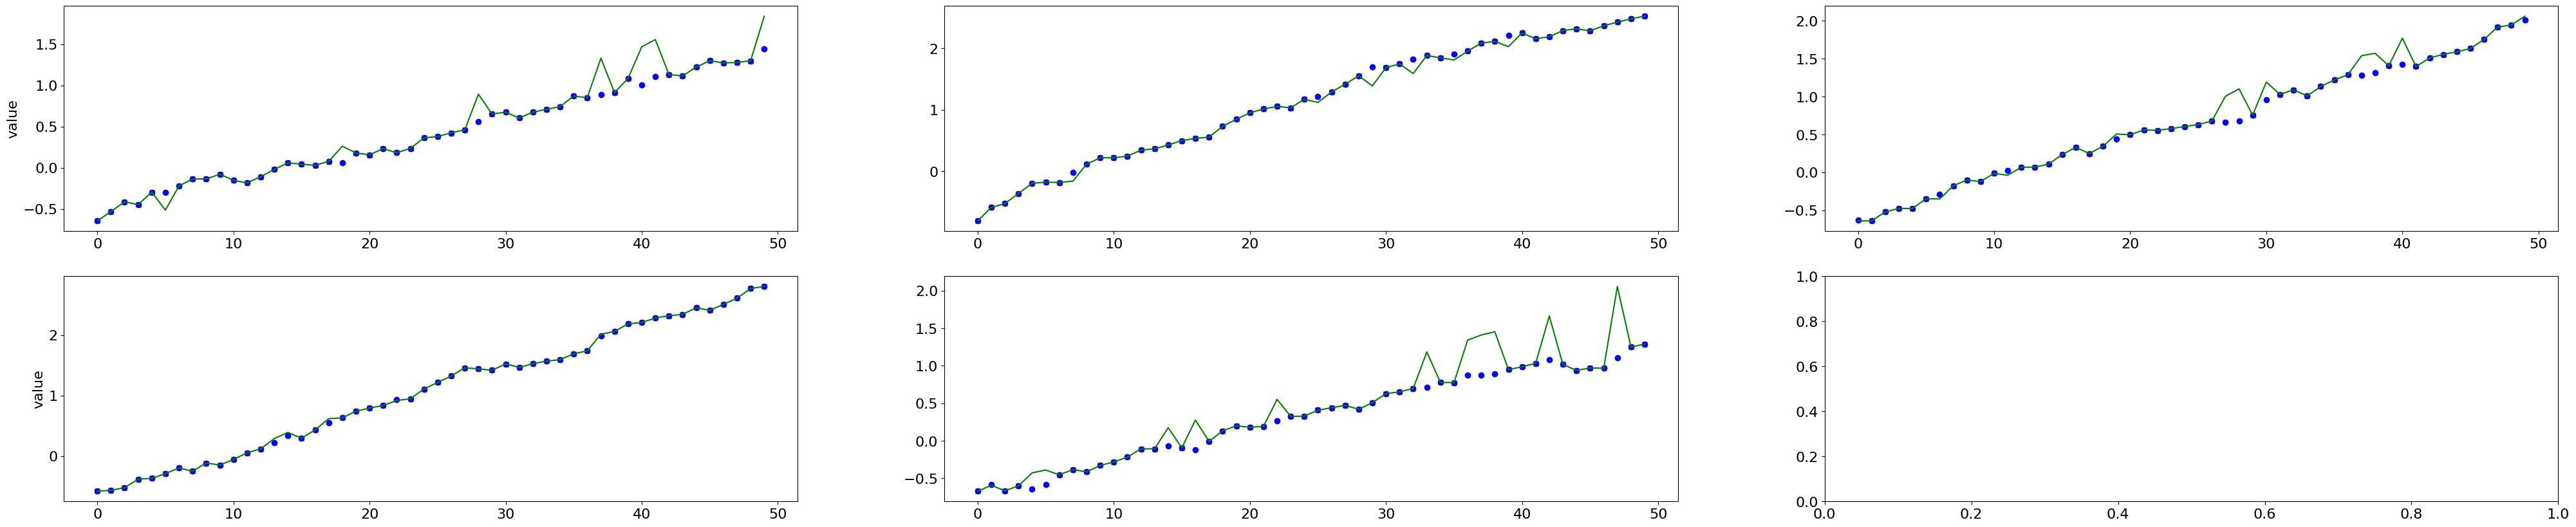

In [80]:
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pypots.utils.logging import logger


# TODO: 优化该画图函数
def plot_data(
    X: np.ndarray,
    X_ori: np.ndarray,
    X_imputed: np.ndarray,
    sample_idx: Optional[int] = None,
    n_rows: int = 10,
    n_cols: int = 4,
    fig_size: Optional[list] = None,
):

    vals_shape = X.shape
    assert len(vals_shape) == 3, "vals_obs should be a 3D array of shape (n_samples, n_steps, n_features)"
    n_samples, n_steps, n_features = vals_shape

    if sample_idx is None:
        sample_idx = np.random.randint(low=0, high=n_samples)
        logger.warning(f"⚠️ No sample index is specified, a random sample {sample_idx} is selected for visualization.")

    if fig_size is None:
        fig_size = [24, 36]

    n_k = n_rows * n_cols
    K = np.min([n_features, n_k])
    L = n_steps
    plt.rcParams["font.size"] = 16
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(fig_size[0], fig_size[1]))

    for k in range(K):
        df = pd.DataFrame({"x": np.arange(0, L), "val": X_imputed[sample_idx, :, k]})
        df1 = pd.DataFrame({"x": np.arange(0, L), "val": X[sample_idx, :, k]})
        df2 = pd.DataFrame({"x": np.arange(0, L), "val": X_ori[sample_idx, :, k]})
        row = k // n_cols
        col = k % n_cols
        axes[row][col].plot(df1.x, df1.val, color="r", marker="x", linestyle="None")
        axes[row][col].plot(df2.x, df2.val, color="b", marker="o", linestyle="None")
        axes[row][col].plot(df.x, df.val, color="g", linestyle="solid")
        if col == 0:
            plt.setp(axes[row, 0], ylabel="value")
        if row == -1:
            plt.setp(axes[-1, col], xlabel="time")

    logger.info("Plotting finished. Please invoke matplotlib.pyplot.show() to display the plot.")


plot_data(
    test_set["X"], 
    test_set["X_ori"], 
    test_set_imputation_results["imputation"],
    0,
    n_rows=2,
    n_cols=3,
    fig_size=[50, 10]
)